In [62]:
!pip install albumentations==0.4.6

In [63]:
import albumentations
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import cv2 as cv
import sys
import importlib
from datetime import datetime
from albumentations import Compose, GaussNoise, Resize, HorizontalFlip, Normalize, ToGray, ShiftScaleRotate
from albumentations.pytorch import ToTensorV2
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook as tqdm

In [64]:
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-16GB


In [65]:
sys.path.append(os.path.abspath('/content/drive/My Drive/Colab Notebooks'))

In [66]:
from Train.Train import Train
from Dataset.DFDC import DFDC
from Eval.Eval import Eval
from Models.Wsdan import WSDAN
from Utils import Wsdan_utils as utils

In [67]:
config_file_path = '/content/drive/My Drive/Colab Notebooks/Config/EfficientB0_Wsdan.py'
visualize_save_path = "/content/drive/MyDrive/Colab Notebooks/Visualize"

import_spec = importlib.util.spec_from_file_location("config", config_file_path)
config = importlib.util.module_from_spec(import_spec)
import_spec.loader.exec_module(config)

In [68]:
TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [69]:
data_transforms = Compose([
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv.BORDER_CONSTANT, p=0.5),
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

data_transforms_test = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [70]:
train_image_datasets = DFDC(TRAINING_DATA_FOLDER, data_transforms)
test_image_datasets = DFDC(TESTING_DATA_FOLDER, data_transforms_test)

In [71]:
writer = SummaryWriter('/content/drive/MyDrive/Colab Notebooks/Tensorboard_Log/Pytorch_WS_DAN/'+str(datetime.now()))

In [72]:
random.seed(323)

In [73]:
device = torch.device("cuda:0")
criterion = nn.CrossEntropyLoss().to(device)
model = WSDAN(num_classes=config.num_classes, M=config.num_attentions, net=config.net)
optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

model = Train(model, train_image_datasets, device, writer, config, utils, batch_size=16)
model, loader = model.run(num_epochs=100, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Loaded pretrained weights for efficientnet-b0
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")



train Loss: 4.0076 Acc: 0.6105



val Loss: 2.1872 Acc: 0.5512

Epoch 2/100



train Loss: 4.4997 Acc: 0.6007



val Loss: 3.8414 Acc: 0.5049

Epoch 3/100



train Loss: 4.9903 Acc: 0.6433



val Loss: 1.5290 Acc: 0.5854

Epoch 4/100



train Loss: 3.9915 Acc: 0.6446



val Loss: 1.0271 Acc: 0.6561

Epoch 5/100



train Loss: 3.7888 Acc: 0.6774



val Loss: 1.1932 Acc: 0.7268

Epoch 6/100



train Loss: 3.7687 Acc: 0.7036



val Loss: 2.2525 Acc: 0.5878

Epoch 7/100



train Loss: 3.3621 Acc: 0.7121



val Loss: 0.8541 Acc: 0.7707

Epoch 8/100



train Loss: 2.9677 Acc: 0.7304



val Loss: 1.0557 Acc: 0.7683

Epoch 9/100



train Loss: 2.6457 Acc: 0.7730



val Loss: 0.6249 Acc: 0.8171

Epoch 10/100



train Loss: 2.2566 Acc: 0.8077



val Loss: 0.6033 Acc: 0.8366

Epoch 11/100



train Loss: 2.3081 Acc: 0.8192



val Loss: 0.5943 Acc: 0.8244

Epoch 12/100



train Loss: 2.3180 Acc: 0.7918



val Loss: 0.6590 Acc: 0.8098

Epoch 13/100



train Loss: 1.9946 Acc: 0.8308



val Loss: 0.5966 Acc: 0.8146

Epoch 14/100



train Loss: 2.0248 Acc: 0.8363



val Loss: 0.5508 Acc: 0.8268

Epoch 15/100



train Loss: 1.7417 Acc: 0.8491



val Loss: 0.5549 Acc: 0.8463

Epoch 16/100



train Loss: 1.7665 Acc: 0.8442



val Loss: 0.6315 Acc: 0.8268

Epoch 17/100



train Loss: 1.6631 Acc: 0.8442



val Loss: 0.5680 Acc: 0.8244

Epoch 18/100



train Loss: 1.5473 Acc: 0.8783



val Loss: 0.4802 Acc: 0.8537

Epoch 19/100



train Loss: 1.5686 Acc: 0.8624



val Loss: 0.5883 Acc: 0.7805

Epoch 20/100



train Loss: 1.5098 Acc: 0.8661



val Loss: 0.4840 Acc: 0.8463

Epoch 21/100



train Loss: 1.4507 Acc: 0.8807



val Loss: 0.4906 Acc: 0.8317

Epoch 22/100



train Loss: 1.4954 Acc: 0.8716



val Loss: 0.5095 Acc: 0.8439

Epoch 23/100



train Loss: 1.4506 Acc: 0.8691



val Loss: 0.4732 Acc: 0.8244

Epoch 24/100



train Loss: 1.3784 Acc: 0.8856



val Loss: 0.5167 Acc: 0.8341

Epoch 25/100



train Loss: 1.3469 Acc: 0.8929



val Loss: 0.4921 Acc: 0.8390

Epoch 26/100



train Loss: 1.3723 Acc: 0.8868



val Loss: 0.4773 Acc: 0.8366

Epoch 27/100



train Loss: 1.3170 Acc: 0.8965



val Loss: 0.5202 Acc: 0.8488

Epoch 28/100



train Loss: 1.3261 Acc: 0.8819



val Loss: 0.4835 Acc: 0.8244

Epoch 29/100



train Loss: 1.2923 Acc: 0.8990



val Loss: 0.4589 Acc: 0.8439

Epoch 30/100



train Loss: 1.2934 Acc: 0.8904



val Loss: 0.4614 Acc: 0.8366

Epoch 31/100



train Loss: 1.2805 Acc: 0.8965



val Loss: 0.4675 Acc: 0.8366

Epoch 32/100



train Loss: 1.2536 Acc: 0.9008



val Loss: 0.4811 Acc: 0.8390

Epoch 33/100



train Loss: 1.2146 Acc: 0.9020



val Loss: 0.4223 Acc: 0.8488

Epoch 34/100



train Loss: 1.2312 Acc: 0.8959



val Loss: 0.4600 Acc: 0.8561

Epoch 35/100



train Loss: 1.2399 Acc: 0.9038



val Loss: 0.4088 Acc: 0.8439

Epoch 36/100



train Loss: 1.2318 Acc: 0.9032



val Loss: 0.4627 Acc: 0.8537

Epoch 37/100



train Loss: 1.1975 Acc: 0.9087



val Loss: 0.4329 Acc: 0.8512

Epoch 38/100



train Loss: 1.2057 Acc: 0.9209



val Loss: 0.4711 Acc: 0.8415

Epoch 39/100



train Loss: 1.2274 Acc: 0.9051



val Loss: 0.4229 Acc: 0.8561

Epoch 40/100



train Loss: 1.1912 Acc: 0.8984



val Loss: 0.4434 Acc: 0.8488

Epoch 41/100



train Loss: 1.1866 Acc: 0.9197



val Loss: 0.4446 Acc: 0.8537

Epoch 42/100



train Loss: 1.2046 Acc: 0.9051



val Loss: 0.4226 Acc: 0.8585

Epoch 43/100



train Loss: 1.2123 Acc: 0.9044



val Loss: 0.4499 Acc: 0.8634

Epoch 44/100



train Loss: 1.2081 Acc: 0.9063



val Loss: 0.4320 Acc: 0.8439

Epoch 45/100



train Loss: 1.2349 Acc: 0.9014



val Loss: 0.3917 Acc: 0.8463

Epoch 46/100



train Loss: 1.2052 Acc: 0.9020



val Loss: 0.4235 Acc: 0.8634

Epoch 47/100



train Loss: 1.2032 Acc: 0.9075



val Loss: 0.4747 Acc: 0.8488

Epoch 48/100



train Loss: 1.1607 Acc: 0.9148



val Loss: 0.4323 Acc: 0.8561

Epoch 49/100



train Loss: 1.1983 Acc: 0.9130



val Loss: 0.4689 Acc: 0.8439

Epoch 50/100



train Loss: 1.1637 Acc: 0.9069



val Loss: 0.4613 Acc: 0.8463

Epoch 51/100



train Loss: 1.2078 Acc: 0.9063



val Loss: 0.4523 Acc: 0.8488

Epoch 52/100



train Loss: 1.1697 Acc: 0.8971



val Loss: 0.4335 Acc: 0.8463

Epoch 53/100



train Loss: 1.1803 Acc: 0.9075



val Loss: 0.4038 Acc: 0.8732

Epoch 54/100



train Loss: 1.1998 Acc: 0.9014



val Loss: 0.4644 Acc: 0.8537

Epoch 55/100



train Loss: 1.1470 Acc: 0.9130



val Loss: 0.4204 Acc: 0.8634

Epoch 56/100



train Loss: 1.1728 Acc: 0.9130



val Loss: 0.4053 Acc: 0.8585

Epoch 57/100



train Loss: 1.1664 Acc: 0.9081



val Loss: 0.4302 Acc: 0.8634

Epoch 58/100



train Loss: 1.1552 Acc: 0.9178



val Loss: 0.4568 Acc: 0.8537

Epoch 59/100



train Loss: 1.1819 Acc: 0.9069



val Loss: 0.4494 Acc: 0.8488

Epoch 60/100



train Loss: 1.1713 Acc: 0.9051



val Loss: 0.4261 Acc: 0.8415

Epoch 61/100



train Loss: 1.1403 Acc: 0.9142



val Loss: 0.4603 Acc: 0.8317

Epoch 62/100



train Loss: 1.1958 Acc: 0.9124



val Loss: 0.4151 Acc: 0.8439

Epoch 63/100



train Loss: 1.1883 Acc: 0.9069



val Loss: 0.3890 Acc: 0.8707

Epoch 64/100



train Loss: 1.1908 Acc: 0.9105



val Loss: 0.4335 Acc: 0.8463

Epoch 65/100



train Loss: 1.1955 Acc: 0.9032



val Loss: 0.3973 Acc: 0.8561

Epoch 66/100



train Loss: 1.1643 Acc: 0.9166



val Loss: 0.4171 Acc: 0.8610

Epoch 67/100



train Loss: 1.1653 Acc: 0.9136



val Loss: 0.4203 Acc: 0.8561

Epoch 68/100



train Loss: 1.1735 Acc: 0.9081



val Loss: 0.3784 Acc: 0.8707

Epoch 69/100



train Loss: 1.1666 Acc: 0.9069



val Loss: 0.4223 Acc: 0.8537

Epoch 70/100



train Loss: 1.1852 Acc: 0.8959



val Loss: 0.4430 Acc: 0.8537

Epoch 71/100



train Loss: 1.1648 Acc: 0.9051



val Loss: 0.4329 Acc: 0.8415

Epoch 72/100



train Loss: 1.1749 Acc: 0.9081



val Loss: 0.4224 Acc: 0.8561

Epoch 73/100



train Loss: 1.1505 Acc: 0.9136



val Loss: 0.3885 Acc: 0.8585

Epoch 74/100



train Loss: 1.1650 Acc: 0.9093



val Loss: 0.4750 Acc: 0.8561

Epoch 75/100



train Loss: 1.1489 Acc: 0.9154



val Loss: 0.4719 Acc: 0.8537

Epoch 76/100



train Loss: 1.1740 Acc: 0.9148



val Loss: 0.4084 Acc: 0.8561

Epoch 77/100



train Loss: 1.1534 Acc: 0.9154



val Loss: 0.4481 Acc: 0.8463

Epoch 78/100



train Loss: 1.1473 Acc: 0.9069



val Loss: 0.4772 Acc: 0.8366

Epoch 79/100



train Loss: 1.1778 Acc: 0.9087



val Loss: 0.4397 Acc: 0.8561

Epoch 80/100



train Loss: 1.1668 Acc: 0.9002



val Loss: 0.4041 Acc: 0.8732

Epoch 81/100



train Loss: 1.1636 Acc: 0.9081



val Loss: 0.4027 Acc: 0.8537

Epoch 82/100



train Loss: 1.1467 Acc: 0.9111



val Loss: 0.3913 Acc: 0.8854

Epoch 83/100



train Loss: 1.2002 Acc: 0.9087



val Loss: 0.4437 Acc: 0.8537

Epoch 84/100



train Loss: 1.1573 Acc: 0.9117



val Loss: 0.4459 Acc: 0.8732

Epoch 85/100



train Loss: 1.1720 Acc: 0.9051



val Loss: 0.4730 Acc: 0.8561

Epoch 86/100



train Loss: 1.1578 Acc: 0.9166



val Loss: 0.4461 Acc: 0.8561

Epoch 87/100



train Loss: 1.1855 Acc: 0.9075



val Loss: 0.4151 Acc: 0.8585

Epoch 88/100



train Loss: 1.1854 Acc: 0.9087



val Loss: 0.4073 Acc: 0.8732

Epoch 89/100



train Loss: 1.2026 Acc: 0.9032



val Loss: 0.4254 Acc: 0.8512

Epoch 90/100



train Loss: 1.1665 Acc: 0.9069



val Loss: 0.4144 Acc: 0.8585

Epoch 91/100



train Loss: 1.1689 Acc: 0.9051



val Loss: 0.4353 Acc: 0.8756

Epoch 92/100



train Loss: 1.1923 Acc: 0.9093



val Loss: 0.4206 Acc: 0.8585

Epoch 93/100



train Loss: 1.1905 Acc: 0.9081



val Loss: 0.4511 Acc: 0.8366

Epoch 94/100



train Loss: 1.1781 Acc: 0.9142



val Loss: 0.4205 Acc: 0.8610

Epoch 95/100



train Loss: 1.1624 Acc: 0.9148



val Loss: 0.4708 Acc: 0.8390

Epoch 96/100



train Loss: 1.1700 Acc: 0.8996



val Loss: 0.4099 Acc: 0.8561

Epoch 97/100



train Loss: 1.1952 Acc: 0.9020



val Loss: 0.4300 Acc: 0.8512

Epoch 98/100



train Loss: 1.1648 Acc: 0.9105



val Loss: 0.4489 Acc: 0.8390

Epoch 99/100



train Loss: 1.1768 Acc: 0.9069



val Loss: 0.4634 Acc: 0.8488

Epoch 100/100



train Loss: 1.1615 Acc: 0.9184



val Loss: 0.4439 Acc: 0.8488

Training complete in 49m 51s
Best val Acc: 0.885366


In [74]:
eval = Eval(model,test_image_datasets,device,utils)

In [75]:
eval.run()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")



F1 Score: 0.7808695652173914
Log Loss: 0.4622123678524683
Confusion Matrix:
[[71 24]
 [18 79]]


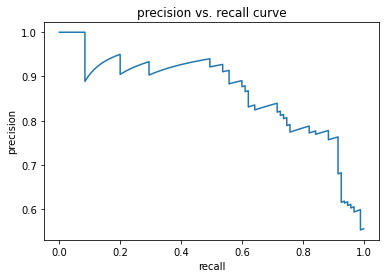

In [76]:
eval.plot_precisionrecall()

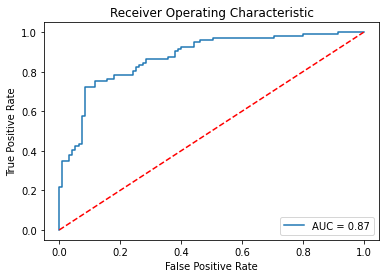

In [77]:
eval.plot_roc()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


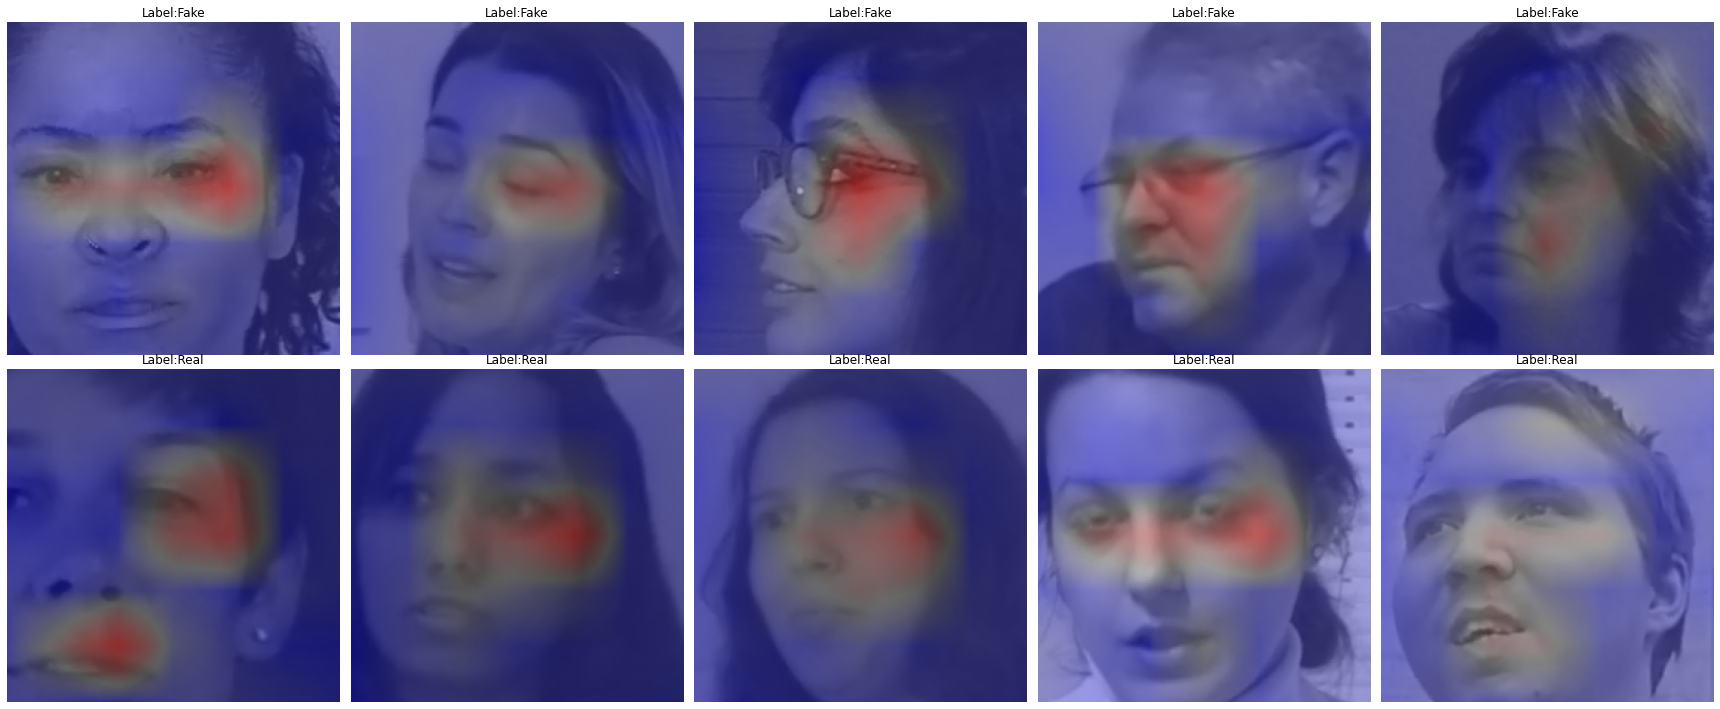

In [78]:
utils.visualize_attention(model,test_image_datasets,device,visualize_save_path)